In [1]:
import pandas as pd

In [2]:
# Load the uploaded CSV file to preview its structure
file_path = 'C:\\Users\\User\\Desktop\\ExtendedRestaurantHTMLDataset.csv'
data = pd.read_csv(file_path)

In [3]:
# Display the first few rows and the column names to understand the structure
data.head(), data.columns

(   Restaurant Name                                          HTML Code
 0  The Local Plate  <!DOCTYPE html>\n    <html lang="en">\n    <he...
 1   Heritage Bites  <!DOCTYPE html>\n    <html lang="en">\n    <he...
 2     Fusion Feast  <!DOCTYPE html>\n    <html lang="en">\n    <he...
 3     Island Taste  <!DOCTYPE html>\n    <html lang="en">\n    <he...
 4     Curry Corner  <!DOCTYPE html>\n    <html lang="en">\n    <he...,
 Index(['Restaurant Name', 'HTML Code'], dtype='object'))

In [4]:
# Check data types and missing values
print(data.info())  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Restaurant Name  1000 non-null   object
 1   HTML Code        1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB
None


In [5]:
#clean the data
data['Restaurant Name'] = data['Restaurant Name'].str.strip()
data['HTML Code'] = data['HTML Code'].str.strip()


In [6]:
#Remove duplicates
data = data.drop_duplicates()


In [7]:
#Prepare for Tokenization
inputs = data['Restaurant Name'].tolist()  # Prompts
outputs = data['HTML Code'].tolist()  # Corresponding HTML


In [8]:
from sklearn.model_selection import train_test_split

# Split into training, validation, and test sets
train_inputs, test_inputs, train_outputs, test_outputs = train_test_split(
    inputs, outputs, test_size=0.2, random_state=42
)
val_inputs, test_inputs, val_outputs, test_outputs = train_test_split(
    test_inputs, test_outputs, test_size=0.5, random_state=42
)


In [9]:
from transformers import T5Tokenizer

# Load the pre-trained tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-small")

# Tokenize the training data
train_encodings = tokenizer(train_inputs, padding=True, truncation=True, max_length=512, return_tensors="pt")
train_labels = tokenizer(train_outputs, padding=True, truncation=True, max_length=512, return_tensors="pt")

# Tokenize validation data
val_encodings = tokenizer(val_inputs, padding=True, truncation=True, max_length=512, return_tensors="pt")
val_labels = tokenizer(val_outputs, padding=True, truncation=True, max_length=512, return_tensors="pt")


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [10]:
#organize tokenized data
train_encodings = tokenizer(train_inputs, padding=True, truncation=True, max_length=512, return_tensors="pt")
train_labels = tokenizer(train_outputs, padding=True, truncation=True, max_length=512, return_tensors="pt")

val_encodings = tokenizer(val_inputs, padding=True, truncation=True, max_length=512, return_tensors="pt")
val_labels = tokenizer(val_outputs, padding=True, truncation=True, max_length=512, return_tensors="pt")


In [11]:
#Create a dataset class to handle tokenized data
import torch

class HTMLDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        return {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "labels": self.labels["input_ids"][idx],
        }

# Create PyTorch Datasets
train_dataset = HTMLDataset(train_encodings, train_labels)
val_dataset = HTMLDataset(val_encodings, val_labels)


In [12]:
from transformers import T5ForConditionalGeneration

# Load the pre-trained T5 model
model = T5ForConditionalGeneration.from_pretrained("t5-small")


C:\Users\User\anaconda3\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
C:\Users\User\anaconda3\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: htt

In [13]:
from transformers import Trainer, TrainingArguments

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",            # Output directory for model checkpoints
    num_train_epochs=3,                # Number of training epochs
    per_device_train_batch_size=8,     # Batch size per device
    per_device_eval_batch_size=8,      # Eval batch size
    save_steps=500,                    # Save model every 500 steps
    save_total_limit=2,                # Limit to 2 checkpoints
    evaluation_strategy="epoch",       # Evaluate after each epoch
    logging_dir="./logs",              # Log directory
    logging_steps=100,                 # Log every 100 steps
)

# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)


C:\Users\User\anaconda3\lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [18]:
trainer.train()


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,4.851200,2.476302
2,2.409100,1.351454
3,1.806200,1.123533


TrainOutput(global_step=300, training_loss=3.022161661783854, metrics={'train_runtime': 4469.9469, 'train_samples_per_second': 0.537, 'train_steps_per_second': 0.067, 'total_flos': 3806488166400.0, 'train_loss': 3.022161661783854, 'epoch': 3.0})

In [19]:
eval_results = trainer.evaluate()
print(eval_results)


{'eval_loss': 1.1235334873199463, 'eval_runtime': 66.5135, 'eval_samples_per_second': 1.503, 'eval_steps_per_second': 0.195, 'epoch': 3.0}


Epoch,Training Loss,Validation Loss
1,1.303800,0.525893
2,0.841500,0.348564
3,0.691400,0.311895


Epoch,Training Loss,Validation Loss
1,0.557400,0.206097
2,0.423800,0.175121
3,0.378200,0.166407


Epoch,Training Loss,Validation Loss
1,0.329800,0.138618
2,0.278000,0.127616
3,0.257600,0.125021


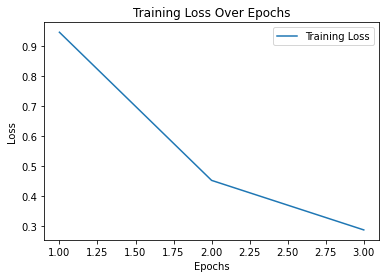

In [24]:
# Initialize a list to store training loss per epoch
training_loss_per_epoch = []

for epoch in range(training_args.num_train_epochs):
    train_output = trainer.train()
    training_loss_per_epoch.append(train_output.metrics['train_loss'])

# Plot training loss
epochs = range(1, len(training_loss_per_epoch) + 1)
plt.plot(epochs, training_loss_per_epoch, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()



In [25]:
trainer.save_model("./final_model")


In [26]:
import torch

# Save the tokenized data
torch.save(train_encodings, "train_encodings.pt")
torch.save(train_labels, "train_labels.pt")
torch.save(val_encodings, "val_encodings.pt")
torch.save(val_labels, "val_labels.pt")

print("Tokenized data saved successfully!")


Tokenized data saved successfully!


In [27]:
# Load the tokenized data
train_encodings = torch.load("train_encodings.pt")
train_labels = torch.load("train_labels.pt")
val_encodings = torch.load("val_encodings.pt")
val_labels = torch.load("val_labels.pt")

print("Tokenized data loaded successfully!")


Tokenized data loaded successfully!


In [29]:
# Test input
test_prompt = "My Fancy Restaurant"

# Tokenize the input
input_ids = tokenizer(test_prompt, return_tensors="pt").input_ids

# Generate output from the model
output_ids = model.generate(input_ids, max_length=512)

# Decode the output to HTML
generated_html = tokenizer.decode(output_ids[0], skip_special_tokens=True)

# Display the result
print("Prompt:", test_prompt)
print("Generated HTML:\n", generated_html)


Prompt: My Fancy Restaurant
Generated HTML:
 !DOCTYPE html> html lang="en"> head> meta charset="UTF-8"> meta name="viewport" content="width=device-width, initial-scale=1.0"> title>My Fancy Restaurant - Home/title> style> body  font-family: Monospace; background: to right, #fcccccccccccccccc, I am a fan
